<a href="https://colab.research.google.com/github/emmaritcey/CISC372/blob/master/Assignment1/FinalModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# model training and tuning
#import all necessary functions and packages
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
#from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

np.random.seed(0)

In [0]:
# download data (-q is the quiet mode)
! wget -q https://www.dropbox.com/s/lhb1awpi769bfdr/test.csv?dl=1 -O test.csv
! wget -q https://www.dropbox.com/s/gudb5eunj700s7j/train.csv?dl=1 -O train.csv


traning 7631


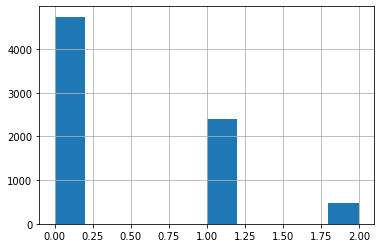

In [0]:
import pandas as pd

Xy_train = pd.read_csv('train.csv', engine='python') #read in training data
X_train = Xy_train.drop(columns=['price_rating']) #drop price_rating column from training data
y_train = Xy_train[['price_rating']] #use price_rating column as training data labels

print('traning', len(X_train))
Xy_train.price_rating.hist() #create histogram of training data labels

In [0]:
X_test = pd.read_csv('test.csv', engine='python') #read in testing data
testing_ids = X_test.Id 
print('testing', len(X_test))

testing 7632


In [0]:
numeric_features = ['bedrooms', 'review_scores_location', 'accommodates', 
                    'beds', 'host_listings_count', 'minimum_nights', 
                    'maximum_nights', 'number_of_reviews', 'review_scores_rating',
                    'review_scores_accuracy', 'review_scores_cleanliness',
                    'review_scores_checkin', 'review_scores_communication',
                    'review_scores_location', 'review_scores_value',
                    'reviews_per_month']
#for numeric features replace all missing values with median of column and use StandardScaler as standardizing method
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = [ 'property_type', 'is_business_travel_ready', 
                        'room_type', 'host_response_time', 'host_is_superhost',
                        'host_identity_verified', 'neighbourhood_cleansed',
                        'instant_bookable', 'cancellation_policy',
                        'require_guest_phone_verification']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [0]:
#create preprocessor that applies the two transformers above to applicable columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [0]:
#create new training and testing dataframes only containing features above
X_train = X_train[[*numeric_features, *categorical_features]]
X_test = X_test[[*numeric_features, *categorical_features]]

In [0]:
#create final pipeline
xgb_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('xgb', XGBClassifier(
                          objective='multi:softmax', seed=1))])

In [0]:
# `__` denotes attribute 
# (e.g. regressor__n_estimators means the `n_estimators` param for `regressor`
#  which is our xgb)
xgb_params = {
    'preprocessor__num__imputer__strategy': ['mean'],
    'xgb__n_estimators': [200],
    'xgb__learning_rate': [0.1],
    'xgb__max_depth':[5],
    'xgb__min_child_weight': [1],
    'xgb__gamma': [0.2],
    'xgb__colsample_bytree': [0.8],
    'xgb__subsample': [0.8]
}

xgb_gs = GridSearchCV(
    xgb_pipe, xgb_params, cv=5, verbose=3, n_jobs=2, 
    scoring='accuracy')
xgb_gs.fit(X_train, y_train)
print('best score {}'.format(xgb_gs.best_score_))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   23.3s finished
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


best score 0.741057384724586


In [0]:
#save best model
xgb_best = xgb_gs.best_estimator_
#see best parameters values
print(xgb_gs.best_params_)

{'preprocessor__num__imputer__strategy': 'mean', 'xgb__colsample_bytree': 0.8, 'xgb__gamma': 0.2, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 5, 'xgb__min_child_weight': 1, 'xgb__n_estimators': 200, 'xgb__subsample': 0.8}


**Neural Network** 


In [0]:
#create final Neural network pipeline
nn_pipe = Pipeline(steps=[('preprocessor', preprocessor), ('nn', MLPClassifier())])

In [0]:
#create a dictionary of all values we want to test for n_estimators
nn_params = {"nn__activation": ["logistic"],
             "nn__solver": ["adam"],
             "nn__alpha": [0.04],
             "nn__max_iter": [300],
             "nn__learning_rate": ['adaptive']
             }
#use gridsearch to test all values for n_estimators
nn_gs = GridSearchCV(nn_pipe, nn_params, cv=5, verbose=3, n_jobs=2, scoring='accuracy')

In [0]:
#fit model to training data
nn_gs.fit(X_train, y_train) 
print('best score {}'.format(nn_gs.best_score_))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.3min finished
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


best score 0.7248077205323831


In [0]:
#save the best model and view best parameter values
nn_best = nn_gs.best_estimator_
print(nn_gs.best_params_)

{'nn__activation': 'logistic', 'nn__alpha': 0.04, 'nn__learning_rate': 'adaptive', 'nn__max_iter': 300, 'nn__solver': 'adam'}


**Random Forest**

In [0]:
#apply preprocessor and xgboost as classifier
rf_pipe = Pipeline(steps=[('preprocessor', preprocessor), ('rf', RandomForestClassifier())])

In [0]:
#create a dictionary of all values we want to test for n_estimators
rf_params = {"rf__n_estimators": [500],
             "rf__max_depth": [60],
             "rf__min_samples_split": [8],
             "rf__min_samples_leaf": [1]
             }
#use gridsearch to test all values for n_estimators
rf_gs = GridSearchCV(rf_pipe, rf_params, cv=5, verbose=3, n_jobs=2, scoring='accuracy')


In [0]:
#fit model to training data
rf_gs.fit(X_train, y_train)
print('best score {}'.format(rf_gs.best_score_))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.3min finished
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


best score 0.7293948764956857


In [0]:
rf_best = rf_gs.best_estimator_
print(rf_gs.best_params_)

{'rf__max_depth': 60, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 8, 'rf__n_estimators': 500}


**ADD VOTING CLASSIFIER** 

In [0]:
#create dictionary of the three models
estimators = [('xgb',xgb_best), ('nn', nn_best), ('rf', rf_best)]

In [0]:
#create voting classifier with the three models
ensemble = VotingClassifier(estimators, voting='hard')

In [0]:
#fit model to training data
ensemble.fit(X_train, y_train)
ensemble.score(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8584720220154632

In [0]:
#make predictions of test data classes
y_pred = ensemble.predict(X_test)

In [0]:
#save predictions
pd.DataFrame(
    {'Id': testing_ids, 'price_rating':y_pred}).to_csv('Emma_submission3.csv', index=False)